<center><h1>Hurricane RI Analaysis: ML</h1></center>

## 📚 <font color='steelblue'>Part 0:</font> Modules 📚

In [1]:
# Data Management/Investigation
import pandas as pd
from pandas.api.types import CategoricalDtype # Ordering categories
import numpy as np
import missingno as miss

# Plotting libraries
from plotnine import *
import matplotlib.pyplot as plt

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.tree import DecisionTreeRegressor as DT_reg
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn import tree # For plotting the decision tree rules

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

# For model interpretation
from sklearn.inspection import (
    permutation_importance,
    partial_dependence, 
    PartialDependenceDisplay, 
    plot_partial_dependence
)

# Misc
import warnings
warnings.filterwarnings("ignore")

In [35]:
import missingno as ms

## 💻 <font color='steelblue'>Part 1:</font> Load and Split Data 💻

In [23]:
# Load Data on Credit Status
dat = pd.read_pickle("12_8_2021.pkl")
dat.shape # display shape

(52717, 20)

In [24]:
dat.head()

,Code,Name,Record,Status,Lat,Lon,Wind,Pressure,DateTime,34kt_radius,50kt_radius,64kt_radius,Bearing,Distance,Speed,Rapid_NHC12,Rapid_NHC24,Rapid_NHC12_Outcome,Rapid_NHC24_Outcome,Accel
0,AL011851,UNNAMED,,HU,28.0,-94.8,80,-999,1851-06-25 00:00:00,-999.0,-999.0,-999.0,0.000000,0.000000,0.000000,False,False,False,False,0.0
1,AL011851,UNNAMED,,HU,28.0,-95.4,80,-999,1851-06-25 06:00:00,-999.0,-999.0,-999.0,-89.859158,31.866664,5.311111,False,False,False,False,0.0
2,AL011851,UNNAMED,,HU,28.0,-96.0,80,-999,1851-06-25 12:00:00,-999.0,-999.0,-999.0,-89.859158,31.866664,5.311111,False,False,False,False,0.0
3,AL011851,UNNAMED,,HU,28.1,-96.5,80,-999,1851-06-25 18:00:00,-999.0,-999.0,-999.0,-77.178366,27.209413,4.534902,False,False,False,False,0.0
4,AL011851,UNNAMED,L,HU,28.2,-96.8,80,-999,1851-06-25 21:00:00,-999.0,-999.0,-999.0,-69.318979,16.999238,5.666413,False,False,False,False,0.0


In [25]:
dat = dat.replace(-999, np.nan)

In [26]:
# Set seed for reproducibility
set_seed = 42069

In [27]:
def xy_splitter(dat, set_seed):
    """
    this method splits the credit status data into training and testing for X and y.
    -----------------
    args: 
        dat (df): dataframe with cerdit status data
        set_seed (int): seed for reproducibility
    returns:
        tuple of 4 dataframes:
            train_X (df): training data for the prediction variables
            test_X (df): testing data for the prediction variables
            train_y (df): training data for the outcome variable
            test_y (df): testing data for the outcome variable
    """
    y = dat['Rapid_NHC24_Outcome'] # outcome variable: credit status (boolean, good or bad)
    X = dat.loc[:, dat.columns != 'Status'] # prediction variables: include all except outcome variable
    return train_test_split(X,y,test_size=.25,random_state=set_seed)

In [28]:
# split credit data into training and testing with prediction and outcome variables
train_X, test_X, train_y, test_y = xy_splitter(dat, set_seed)

## 📊 <font color='steelblue'>Part 2:</font> Examine the Training Data 📊

### Unit of Analysis

The unit of analysis is a single person, and for each person, we are determining whether they have a good or bad credit status based on the predictors.

### Data Types

Some data types (strings) do not work well with our ML pipeline, so we fix those in preprocessing.

In [29]:
train_X.dtypes # display data types

Code                           object
Name                           object
Record                         object
Lat                           float64
Lon                           float64
Wind                            int32
Pressure                      float64
DateTime               datetime64[ns]
34kt_radius                   float64
50kt_radius                   float64
64kt_radius                   float64
Bearing                       float64
Distance                      float64
Speed                         float64
Rapid_NHC12                    object
Rapid_NHC24                    object
Rapid_NHC12_Outcome            object
Rapid_NHC24_Outcome            object
Accel                         float64
dtype: object

### Data Completeness

Missing data can cause headaches in the ML pipeline, so we we examine and remove missing values in preprocessing.

In [30]:
# Count missing values in each column (note we are checking the full data, not just training)
for col in dat.columns: 
    print(dat[col].isna().sum(),'\t', col)

0 	 Code
0 	 Name
0 	 Record
0 	 Status
0 	 Lat
0 	 Lon
0 	 Wind
30960 	 Pressure
0 	 DateTime
43616 	 34kt_radius
43616 	 50kt_radius
43616 	 64kt_radius
0 	 Bearing
0 	 Distance
0 	 Speed
0 	 Rapid_NHC12
0 	 Rapid_NHC24
0 	 Rapid_NHC12_Outcome
0 	 Rapid_NHC24_Outcome
0 	 Accel


<AxesSubplot:>

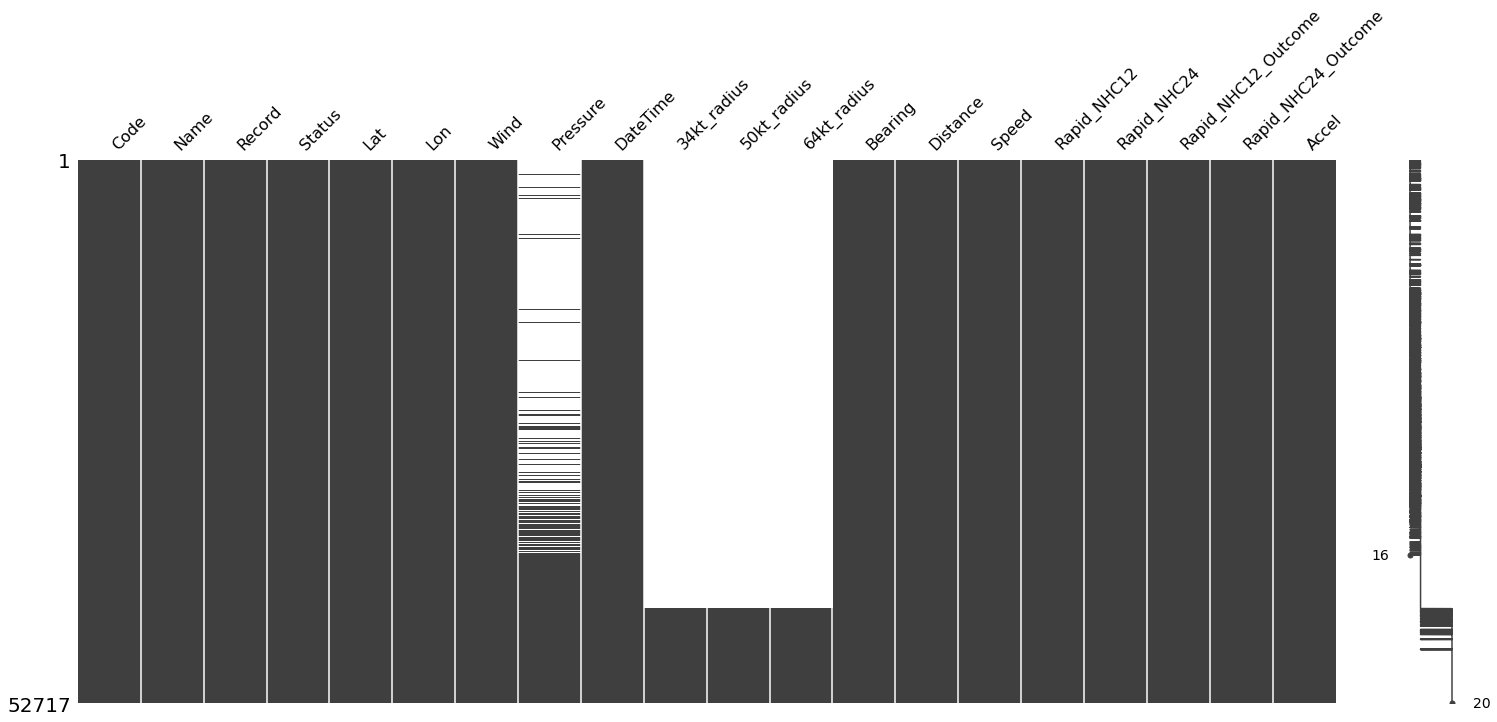

In [37]:
ms.matrix(dat)

### Data Variation and Distribution

Now let's get a 'feel' for the data by checking out the distributions. 

Note, now we need to be extremely careful to **only view the training data**, or else we could end up in machine learning hell. 👹 👹 

First, looking at the outcome variable, it appears that 2/3 of people receive a 'good' credit rating while 1/3 of people get a 'bad' rating.

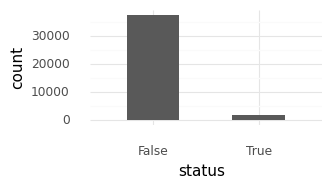

In [33]:
( # Display distribution of outcome variable Credit Status (training only, duh)
    ggplot(pd.DataFrame(dict(status=train_y)), aes(x="status")) +
    geom_histogram(bins=3) +
    theme_minimal() +
    theme(figure_size = (3,1.5))
).draw();

Next, let's look at categorical variables, again **only looking at the training data**.

In [ ]:
d = train_X.select_dtypes(include="object").melt() # melt numeric categorical columns together

( # Display distribution of categorical prediction variables
    ggplot(d,aes(x="value")) +
    geom_bar() +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(6,3), subplots_adjust={'wspace':0.25, 'hspace':1.25}, axis_text_x=element_text(rotation=45, hjust=1))
).draw();

Lastly, we check out the numeric data columns. Here we encounter some pretty skewed distributions that will need to be fixed.

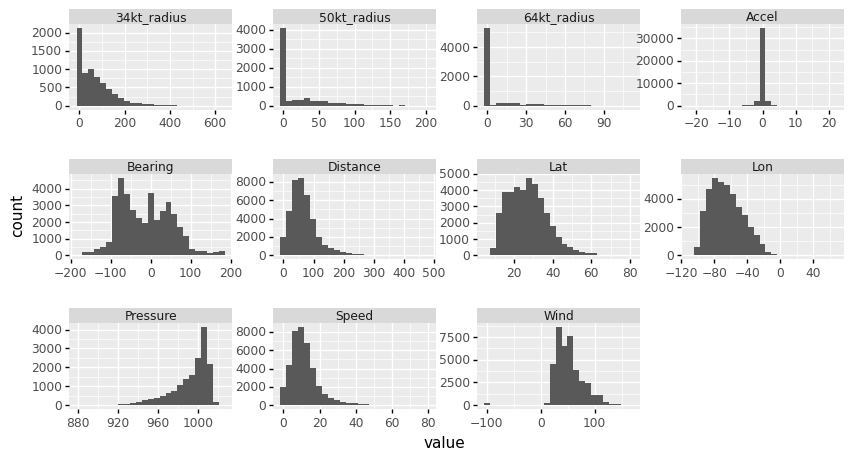

In [34]:
numerics = ['int16','int32','int64','float16','float32','float64'] # list of all numeric types
d = train_X.select_dtypes(include=numerics).melt() # melt numeric columns together

( # Display distribution of integer prediction variables
    ggplot(d,aes(x="value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(10,5), subplots_adjust={'wspace':0.25, 'hspace':0.75})
).draw();

### Data Examination Conclusions and High Level Preprocessing

In my exploration, I learned that this data is very clean and only needs a little work before it is ready for the ML pipeline. There are missing data points in multiple variables, but these missing points do not make a majority of the variables, so we simply remove those rows with missing values.

In addition, several of the prediction variables have highly skewed distributions, something that could affect the accuracy of our model later. To fix this, we will take the natural log of these variables with the goal of 'unskewing' the distributions.

Most of these look good after taking the log, but the Debt and Assets variables both have a considerable portion of the values at 0. 

To fix these, we transform these into categorical variables with three categories,

0. (Debt/Assets) are 0
1. (Debt/Assets) are below median (excluding 0's in median calculation)
2. (Debt/Assets) are above median (excluding 0's in median calculation)

In [ ]:
## Fix missing data
dat = dat.dropna()

## Take log of variables to unskew
# list of variables we want to logify
to_Log = ['Price','Expenses','Income','Amount','Debt','Assets','Seniority'] 
for col in to_Log: # iterate through the list and take the natural log of each column
    dat[f"ln_{col}"] = np.log(dat[col] + 1)

## Transform Debt and Assets into categorical variable, as described above
for col in ['Debt','Assets']:
    median = dat.loc[dat[col] > 0,col].median()
    dat[f'cat_{col}'] =  np.where(dat[col]==0,0,np.where(dat[col] <= median,1,2))

## Convert object columns to category data type
dat_cat = dat.select_dtypes(['object']) # get dataframe with only object columns
dat[dat_cat.columns] = dat_cat.apply(lambda x: x.astype('category')) # convert object columns to categorical
dat[['cat_Debt','cat_Assets']] = dat[['cat_Debt','cat_Assets']].apply(lambda x: x.astype('category'))

cat_columns = dat.select_dtypes(['category']).columns # get dataframe with only object columns
dat[cat_columns] = dat[cat_columns].apply(lambda x: x.cat.codes)

## ➡️ <font color='steelblue'>Part 3:</font> Build the ML Pipeline ➡️

In [ ]:
dat = dat[['Status','Seniority', 'Home', 'Time', 'Age', 'Records', 'Job',
           'ln_Expenses', 'ln_Income', 'cat_Assets', 'ln_Amount', 'ln_Price']]

# Re-split data since we modified original dataframe
train_X, test_X, train_y, test_y = xy_splitter(dat, set_seed)

In [ ]:
# Set the folds index to ensure comparable samples, use 5 folds with set seed 202011
fold_generator = KFold(n_splits=5, shuffle=True,random_state=set_seed)

In [ ]:
# Create Pipeline using built in pre-processing and MinMaxScaler, set default model to None
pipe = Pipeline(steps=[('pre_process', pp.MinMaxScaler()),('model',None)])

In [ ]:
# Create model search space with tuning parameters using four models defined in assignment:
# Naive Bayes, K-nearest Neighbors, Decision Tree, Random Forest

search_space = [

    # NaiveBayes
    {'model': [NB()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[5,10,20,40,60,80,100,125,150,200,300,400]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DT()],
     'model__max_depth':[2,3,4,5,6,7,8,9,10]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
    'model__max_depth':[2,3,4,5,6,7,8,9,10],
    'model__n_estimators':[250,500,750,1000,1250,1500]}

]

In [ ]:
# define grid search function 
search = GridSearchCV(pipe, search_space, cv = fold_generator, scoring='roc_auc', n_jobs=4)

## 🎆 <font color='steelblue'>Part 4:</font> Run the Models 🎆

In [ ]:
# Search through each model, this is where the magic happens 
search.fit(train_X,train_y)

In [ ]:
# Best score, per ROC AUC metric
search.best_score_

In [ ]:
# Model with the best parameters
search.best_params_

In [ ]:
# define a variable allowing us to use the estimator more later
rf_mod = search.best_estimator_

## 🔎 <font color='steelblue'>Part 5:</font> Idenitfy Best Model 🔎

In [ ]:
# ROC AUC score for the best model (defined above) for the training data
m.roc_auc_score(train_y, rf_mod.predict_proba(train_X)[:,1])

In [ ]:
# Accuracy score (percentage correct) for the best model on the training data
m.accuracy_score(train_y, rf_mod.predict(train_X))

The best preforming model was the Random Forest with depth 8 and 1250 estimators. Throughout my testing, the random forest model consistently preformed the best of the four, althought the tuning parameters often varied.

## 🔮 <font color='steelblue'>Part 6:</font> Model Interpretation 🔮

### Permutation Importance

We remove one variable at a time (permutation) to back solve and find the most important predicition variable.

In [ ]:
vi = permutation_importance(rf_mod,train_X,train_y,n_repeats=25)

In [ ]:
# Organize permutation importance as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns, vi = vi['importances_mean'], std = vi['importances_std']))

# Generate confidence intervals (using t-stat of 2)
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# Order variables from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)
vi_dat

As you can see from the table, the variables with the highest importance were (in order) Records, ln_Income, and Job, each with greater than 0.054 vi. Although, all of the included variables seem to have a reasonable sized proportional effect on Y. The least important variable is only 3.5 times less important than the most important. It's not as though one variable reigns supreme overall. However, Records is clearly the most important, with 0.02 more vi than any other.

In [ ]:
( # Plot permutation importance with error bars showing 95% confidence interval
    ggplot(vi_dat, aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    ggtitle('Permutation Importance of Variable') +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
).draw();

### Partial Dependency

In [ ]:
# Target specific features (those that matter the most, per permutation importance)
features = ['Records','ln_Income','Job','Seniority','ln_Amount']

# Calculate the partial dependency and plot
fig, ax = plt.subplots(figsize=(15, 4))
plt.title('Partial Dependency Plots', fontsize=18, pad=10)
display = plot_partial_dependence(rf_mod, train_X, features,n_cols=5, n_jobs=4, grid_resolution=30,ax=ax)

### Partial Dependency Interaction

In [ ]:
# Feed in the ineraction pairs as a nested list
interacted_features = [['Records','ln_Income'],['Job','ln_Income'],['Job','Records']] 

# Calculate the partial dependency interaction and plot
fig, ax = plt.subplots(figsize=(12, 4))
plt.title('Partial Dependency Interaction Plots', fontsize=18, pad=10)
display = plot_partial_dependence(rf_mod, train_X, interacted_features, n_cols=3, n_jobs=4, grid_resolution=100,ax=ax)
fig.tight_layout()

The marginal relationships tell us how the predicted outcome variable will change when we vary the interaction variables, while holding all else constast. As you can expect, they are very similar to the regular partial dependency plots but they allow us to vary two variable at once, how useful! We should be wary of these when using dummy independent variables. For example, Records is binary (only values 0 and 1) so considering Records at 0.6 in the partial dependency plots doesn't make much sense. Instead, we can only consider the places where Records equals 0 or 1.

### Individual Conditional Expectation (ICE)

In [ ]:
# Target specific features (those that matter the most, per permutation importance)
features = ['Records','ln_Income']

# Calculate ICE and display plots
fig, ax = plt.subplots(figsize=(6, 4))
plt.title('Individual Conditional Expectation Plots', fontsize=18, pad=10)
display = PartialDependenceDisplay.from_estimator(
    rf_mod,
    train_X,
    features,
    kind="both", # "average" = just PDP, "individual" = just ICE
    subsample=50,
    n_jobs=3,
    grid_resolution=20,
    random_state=0,
    ice_lines_kw={"color": "tab:blue", "alpha": 0.2, "linewidth": 0.5},
    pd_line_kw={"color": "tab:orange", "linestyle": "--"},
    n_cols=len(features),
    ax = ax
)
display.figure_.subplots_adjust(hspace=0.3)

Yes, we can clearly see heterogeneity when observing the ICE plots. For the most important variable, Records, it is a bit harder to see (since it's a dummy variable) but we can tell that not of the lines have the same slope. More clearly  in the second most important variable, ln_Income, we can see that there is clear heterogeneity in the observations. The heterogeneity indicates that the independent variable will have varying affects based on the initial partial dependence. For example, someone with a low propensity for a loan does not see the same impact of Income on their chances as someone who began with a high propensity for the loan.

## 🧠 <font color='steelblue'>Part 7:</font> Hypothesization 🧠

I struggled to make a hypotehsis because I am unsure exactly what the Records variable actually means (and other people including Prof Dunford have conflicting views on the meaning) SO I choose to believe it means a criminal records: 0 if no criminal record, 1 if the person does have a criminal record.

My hypothesis is that the credit agency (or whoever is assigning the credit status) cares most about the ability of that individual to make money and not steal it. Three of the top four categories are job related, specifically what type of job, years at the job, and income. All of these affect the ability of someone to make the money back to pay the loan. The algorithm shows less care about other things like Debt and Expenses which is surprising to me. It seems the credit agency cares more about ability to make money to pay back the loan now but not the other obstacles in a persons life like previous debt or expenses. The final variable, criminal record, isn't job related, but seems like something a credit agency would care a lot about. They don't want to give money to someone with a criminal history, so it is not surprsing to me that this is the most important variable. To explore this analysis further, I would be interested first in learning what exactly Records means. Then, I would test how correlated each of the job related variables are. Perhaps there is some comination of them that produces the best model, but I could not find what it was. Beyond that, I am sure the insurance company has more information about each person, knowing those categories may help fine tune our model in the future.